In [0]:
!ls


sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir train
!mkdir train/128

In [0]:
!cp '/content/drive/My Drive/kaggle/bengali/input/grapheme-imgs-128x128.zip' train
!cp '/content/drive/My Drive/kaggle/bengali/input/train_with_fold.csv' train

In [0]:
!unzip train/grapheme-imgs-128x128.zip  -d train/128/

In [0]:
!ls train

128  grapheme-imgs-128x128.zip	train_with_fold.csv


In [0]:
!pip install q keras==2.3.1.

     |████████████████████████████████| 378kB 6.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!python -c 'import keras; print(keras.__version__)'

Using TensorFlow backend.
2.3.1


In [0]:
%tensorflow_version 2.x

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12341662108773102776, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13941736096913164753
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1478538252126747260
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3480571039397160235
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import math
import keras
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau,LambdaCallback
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
train_dir='./train/128'

In [0]:
dataset_np = pd.read_csv('./train/train_with_fold.csv').to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]
fold = 0

valid_m = np.where(dataset_np[:,6]==fold)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != fold)
fold_valid_inds = np.where(dataset_np[:,6] == fold)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [0]:
#densenet_weights = './train/DenseNet-BC-121-32-no-top.h5'
densenet = DenseNet121(include_top=False, weights=None, input_shape=(128, 128, 3))

In [0]:
def build_head(x_in, n, name=None):
  x = layers.GlobalAveragePooling2D()(x_in)
  x = Activation('Mish', name='mish_act1_'+name) (x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(512)(x)
  x = Activation('Mish', name='mish_act2_'+name) (x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(n, name=name, activation='softmax')(x)
  return x

In [0]:
def build_model(densenet):
    x_in = layers.Input(shape=(128, 128, 3))
    x = densenet(x_in)
    out_root = build_head(x, 168,'root')
    out_vowel = build_head(x, 11,'vowel')
    out_consonant = build_head(x,7,'consonant')
    
    model = tf.keras.Model(inputs=x_in, outputs=[out_root, out_vowel, out_consonant])
    
    return model

In [0]:
model = build_model(densenet)

In [0]:
for (n, layer) in enumerate(model.layers[1].layers):
  if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
        print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
        layer.activation = Mish(mish)
        print('-> {}'.format(layer.activation))

replacing #4: <tensorflow.python.keras.layers.core.Activation object at 0x7f33e0d5fba8>, <function relu at 0x7f33e24432f0>
-> <__main__.Mish object at 0x7f3395c475f8>
replacing #8: <tensorflow.python.keras.layers.core.Activation object at 0x7f339a5fe518>, <function relu at 0x7f33e24432f0>
-> <__main__.Mish object at 0x7f3395c477f0>
replacing #11: <tensorflow.python.keras.layers.core.Activation object at 0x7f339a5a3da0>, <function relu at 0x7f33e24432f0>
-> <__main__.Mish object at 0x7f3395c47908>
replacing #15: <tensorflow.python.keras.layers.core.Activation object at 0x7f339a555ba8>, <function relu at 0x7f33e24432f0>
-> <__main__.Mish object at 0x7f3395c47a90>
replacing #18: <tensorflow.python.keras.layers.core.Activation object at 0x7f339a583cc0>, <function relu at 0x7f33e24432f0>
-> <__main__.Mish object at 0x7f3395c47c18>
replacing #22: <tensorflow.python.keras.layers.core.Activation object at 0x7f339a536ba8>, <function relu at 0x7f33e24432f0>
-> <__main__.Mish object at 0x7f3395c4

In [0]:
import tempfile

def apply_modifications(model, custom_objects=None):
    """Applies modifications to the model layers to create a new Graph. For example, simply changing
    `model.layers[idx].activation = new activation` does not change the graph. The entire graph needs to be updated
    with modified inbound and outbound tensors because of change in layer building function.
    Args:
        model: The `keras.models.Model` instance.
    Returns:
        The modified model with changes applied. Does not mutate the original `model`.
    """
    # The strategy is to save the modified model and load it back. This is done because setting the activation
    # in a Keras layer doesnt actually change the graph. We have to iterate the entire graph and change the
    # layer inbound and outbound nodes with modified tensors. This is doubly complicated in Keras 2.x since
    # multiple inbound and outbound nodes are allowed with the Graph API.
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)

In [0]:
model = apply_modifications(model, custom_objects={'mish':Mish(mish)})

In [0]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf


@tf.keras.utils.register_keras_serializable(package='Addons')
class Lookahead(tf.keras.optimizers.Optimizer):
    """This class allows to extend optimizers with the lookahead mechanism.
    The mechanism is proposed by Michael R. Zhang et.al in the paper
    [Lookahead Optimizer: k steps forward, 1 step back]
    (https://arxiv.org/abs/1907.08610v1). The optimizer iteratively updates two
    sets of weights: the search directions for weights are chosen by the inner
    optimizer, while the "slow weights" are updated each `k` steps based on the
    directions of the "fast weights" and the two sets of weights are
    synchronized. This method improves the learning stability and lowers the
    variance of its inner optimizer.
    Example of usage:
    ```python
    opt = tf.keras.optimizers.SGD(learning_rate)
    opt = tfa.optimizers.Lookahead(opt)
    ```
    """

    def __init__(self,
                 optimizer,
                 sync_period=6,
                 slow_step_size=0.5,
                 name="Lookahead",
                 **kwargs):
        r"""Wrap optimizer with the lookahead mechanism.
        Args:
            optimizer: The original optimizer that will be used to compute
                and apply the gradients.
            sync_period: An integer. The synchronization period of lookahead.
                Enable lookahead mechanism by setting it with a positive value.
            slow_step_size: A floating point value.
                The ratio for updating the slow weights.
            name: Optional name for the operations created when applying
                gradients. Defaults to "Lookahead".
            **kwargs: keyword arguments. Allowed to be {`clipnorm`,
                `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients
                by norm; `clipvalue` is clip gradients by value, `decay` is
                included for backward compatibility to allow time inverse
                decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """
        super(Lookahead, self).__init__(name, **kwargs)

        if isinstance(optimizer, str):
            optimizer = tf.keras.optimizers.get(optimizer)
        if not isinstance(optimizer, tf.keras.optimizers.Optimizer):
            raise TypeError(
                "optimizer is not an object of tf.keras.optimizers.Optimizer")

        self._optimizer = optimizer
        self._set_hyper('sync_period', sync_period)
        self._set_hyper('slow_step_size', slow_step_size)
        self._initialized = False

    def _create_slots(self, var_list):
        self._optimizer._create_slots(var_list=var_list)  # pylint: disable=protected-access
        for var in var_list:
            self.add_slot(var, 'slow')

    def _create_hypers(self):
        self._optimizer._create_hypers()  # pylint: disable=protected-access

    def _prepare(self, var_list):
        return self._optimizer._prepare(var_list=var_list)  # pylint: disable=protected-access

    def apply_gradients(self, grads_and_vars, name=None):
        self._optimizer._iterations = self.iterations  # pylint: disable=protected-access
        return super(Lookahead, self).apply_gradients(grads_and_vars, name)

    def _init_op(self, var):
        slow_var = self.get_slot(var, 'slow')
        return slow_var.assign(
            tf.where(
                tf.equal(self.iterations,
                         tf.constant(0, dtype=self.iterations.dtype)),
                var,
                slow_var,
            ),
            use_locking=self._use_locking)

    def _look_ahead_op(self, var):
        var_dtype = var.dtype.base_dtype
        slow_var = self.get_slot(var, 'slow')
        local_step = tf.cast(self.iterations + 1, tf.dtypes.int64)
        sync_period = self._get_hyper('sync_period', tf.dtypes.int64)
        slow_step_size = self._get_hyper('slow_step_size', var_dtype)
        step_back = slow_var + slow_step_size * (var - slow_var)
        sync_cond = tf.equal(
            tf.math.floordiv(local_step, sync_period) * sync_period,
            local_step)
        with tf.control_dependencies([step_back]):
            slow_update = slow_var.assign(
                tf.where(
                    sync_cond,
                    step_back,
                    slow_var,
                ),
                use_locking=self._use_locking)
            var_update = var.assign(
                tf.where(
                    sync_cond,
                    step_back,
                    var,
                ),
                use_locking=self._use_locking)
        return tf.group(slow_update, var_update)

    @property
    def weights(self):
        return self._weights + self._optimizer.weights

    def _resource_apply_dense(self, grad, var):
        init_op = self._init_op(var)
        with tf.control_dependencies([init_op]):
            train_op = self._optimizer._resource_apply_dense(grad, var)  # pylint: disable=protected-access
            with tf.control_dependencies([train_op]):
                look_ahead_op = self._look_ahead_op(var)
        return tf.group(init_op, train_op, look_ahead_op)

    def _resource_apply_sparse(self, grad, var, indices):
        init_op = self._init_op(var)
        with tf.control_dependencies([init_op]):
            train_op = self._optimizer._resource_apply_sparse(  # pylint: disable=protected-access
                grad, var, indices)
            with tf.control_dependencies([train_op]):
                look_ahead_op = self._look_ahead_op(var)
        return tf.group(init_op, train_op, look_ahead_op)

    def get_config(self):
        config = {
            'optimizer': tf.keras.optimizers.serialize(self._optimizer),
            'sync_period': self._serialize_hyperparameter('sync_period'),
            'slow_step_size': self._serialize_hyperparameter('slow_step_size'),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @property
    def learning_rate(self):
        return self._optimizer._get_hyper('learning_rate')

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self._optimizer._set_hyper('learning_rate', learning_rate)

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, lr):
        self.learning_rate = lr

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer = tf.keras.optimizers.deserialize(
            config.pop('optimizer'),
            custom_objects=custom_objects,
        )
        return cls(optimizer, **config)

In [0]:
loss_dict={'root': 'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
           
metrics_dict={ 'root':     [keras.metrics.Recall(name='recall')],
               'vowel':    [keras.metrics.Recall(name='recall')],
              'consonant': [keras.metrics.Recall(name='recall')]}

#metrics_dict={ 'root':     ['accuracy'],
#               'vowel':    ['accuracy'],
#               'consonant':['accuracy']}


opt = Lookahead(tf.keras.optimizers.Adam(1e-3))
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[2.0,1.0,1.0], 
                  metrics=metrics_dict)

In [0]:
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   shear_range = 0.1)

valid_datagen = ImageDataGenerator() 

In [0]:
columns=["root_class","vowel_class", "cons_class"]
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col="filename",
        y_col=columns,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="multi_output",
        colormode="greyscale")

valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=train_dir,
        x_col="filename",
        y_col=columns,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode="multi_output",
        colormode="greyscale")

Found 160672 validated image filenames.
Found 40168 validated image filenames.


In [0]:
def split_into_3_outputs(y_batch):
    
    y1=tf.keras.utils.to_categorical(y_batch[0],168)
    y2=tf.keras.utils.to_categorical(y_batch[1],11)
    y3=tf.keras.utils.to_categorical(y_batch[2],7)
    
    return y1,y2,y3

In [0]:
def aux_data_gen(generator):
    stats = (0.0692, 0.2051)
    while True:
        batch = next(generator)
        batch_x = (batch[0].astype(np.float32)/255.0 - stats[0])/stats[1]
        yield batch_x, split_into_3_outputs(batch[1])

In [0]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0, epoch_offset=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.epoch_offset = epoch_offset

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * (epoch + self.epoch_offset) / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [0]:
epochs = 10

ca_shed = CosineAnnealingScheduler(T_max=40, eta_max=1e-3, eta_min=1e-6,verbose=1, epoch_offset=0)

history=model.fit_generator(aux_data_gen(train_generator),
                    validation_data=aux_data_gen(valid_generator),
                    epochs=epochs,
                    steps_per_epoch=train_m//batch_size+1,
                    validation_steps = valid_m//batch_size+1,
                    callbacks=[ca_shed])

history.history['weighted_recall']= 0.5*np.array(history.history['root_recall'])+0.25*np.array(history.history['consonant_recall'])+0.25*np.array(history.history['vowel_recall'])
history.history['val_weighted_recall']= 0.5*np.array(history.history['val_root_recall'])+0.25*np.array(history.history['val_consonant_recall'])+0.25*np.array(history.history['val_vowel_recall'])

model.save_weights('/content/drive/My Drive/kaggle/bengali/output/w_md121_eps10_sr02_bs32_do02_la-adam_fold'+str(fold)+'.h5')
model.save('/content/drive/My Drive/kaggle/bengali/output/m_md121_eps10_sr02_bs32_do02_la-adam_fold'+str(fold)+'.h5')
pd.DataFrame(history.history).to_csv('/content/drive/My Drive/kaggle/bengali/output/h_md121_eps10_sr02_bs32_do02_la-adam_fold'+str(fold)+'.csv', index=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 5022 steps, validate for 1256 steps

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.001.
Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
5022/5022 [==============================] - 1077s 214ms/step - loss: 2.8387 - root_loss: 1.1036 - vowel_loss: 0.3297 - consonant_loss: 0.3019 - root_recall: 0.4244 - vowel_recall: 0.7926 - consonant_recall: 0.7995 - val_loss: 1.3331 - val_root_loss: 0.5029 - val_vowel_loss: 0.1744 - val_consonant_loss: 0.1529 - val_root_recall: 0.6590 - val_vowel_recall: 0.8896 - val_consonant_recall: 0.8994

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.0009984602081996976.
Epoch 2/10
5022/5022 [==============================] - 1000s 199ms/step - loss: 1.1637 - root_loss: 0.4363 - vowel_loss: 0.1506 - consonant_loss: 0.1405 - root_recall: 0.7211 - vowel_recall: 0.9097 - consonant_recall: 0.9176 - val_

In [0]:
model.optimizer.get_config()

{'name': 'Lookahead',
 'optimizer': {'class_name': 'Adam',
  'config': {'amsgrad': False,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'decay': 0.0,
   'epsilon': 1e-07,
   'learning_rate': 0.00088032277,
   'name': 'Adam'}},
 'slow_step_size': 0.5,
 'sync_period': 6}

In [0]:
from matplotlib import pyplot as plt

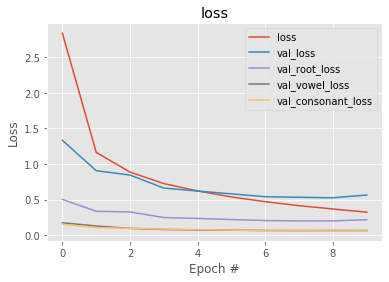

In [0]:
%matplotlib inline

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label='loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, epochs), history.history['val_root_loss'], label='val_root_loss')
plt.plot(np.arange(0, epochs), history.history['val_vowel_loss'], label='val_vowel_loss')
plt.plot(np.arange(0, epochs), history.history['val_consonant_loss'], label='val_consonant_loss')

    
plt.title('loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

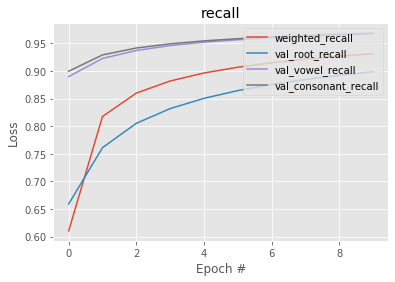

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['weighted_recall'], label='weighted_recall')
plt.plot(np.arange(0, epochs), history.history['val_root_recall'], label='val_root_recall')
plt.plot(np.arange(0, epochs), history.history['val_vowel_recall'], label='val_vowel_recall')
plt.plot(np.arange(0, epochs), history.history['val_consonant_recall'], label='val_consonant_recall')

    
plt.title('recall')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

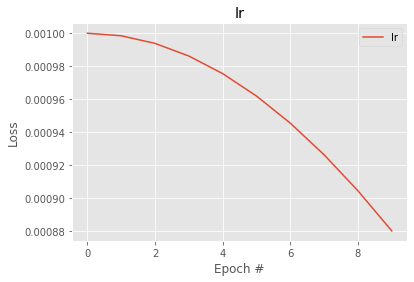

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['lr'], label='lr')

    
plt.title('lr')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

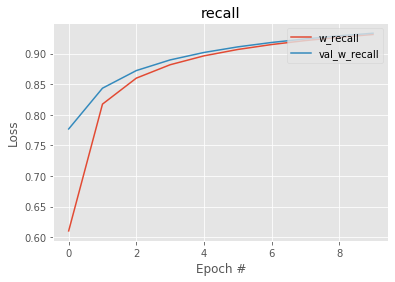

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['weighted_recall'], label='w_recall')
plt.plot(np.arange(0, epochs), history.history['val_weighted_recall'], label='val_w_recall')
    
plt.title('recall')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()